# Stochastic SIS Model

Let's first define some global parameters of our model.

In [159]:
!pip install --upgrade tqdm

In [160]:
# from scipy.stats import poisson
import numpy as np
from numpy.random import poisson, exponential, binomial
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [1]:
N = 1e6 #population size
beta = 1.5 #contact rate
alpha = 0.5 #recovery rate
I = 1 #one initially infected person
dt = 1 #time unit

## Model without immunity : Recovered = Susceptible

In [17]:
def new_contaminated(I=1, dt=dt, beta=beta, N=N):
    return min(N-I, poisson(beta*(1-I/N)*I*dt))
def new_recovered(I=1, dt=dt, alpha=alpha):
    return min(I, poisson(alpha*I*dt))
def new_infected(I=1, dt=dt, alpha=alpha, beta=beta, N=N):
    return max(0, I + new_contaminated(I, dt=dt, beta=beta, N=N) - new_recovered(I, dt=dt, alpha=alpha))

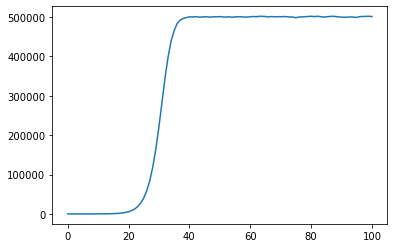

In [29]:
np.random.seed(0)
I = 1
evolution = [1]
for t in range(100):
    I = new_infected(I, alpha=0.5, beta=1)
    evolution.append(I)
plt.plot(evolution)
plt.show()

## Model with immunity : when recovered, you cannot be susceptible again

In [30]:
def new_contaminated(I=1, R=0, dt=dt, beta=beta, N=N):
    return min(N-R-I, poisson(beta*(1-(R+I)/N)*I*dt))
def new_recovered(I=1, dt=dt, alpha=alpha):
    return min(I, poisson(alpha*I*dt))
def new_infected(I=1, R=0, dt=dt, alpha=alpha, beta=beta, N=N):
    R_new = new_recovered(I=I, dt=dt, alpha=alpha)
    I_new = new_contaminated(I=I, R=R, dt=dt, beta=beta, N=N)
    return max(0, I + I_new - R_new), min(N, R + R_new)

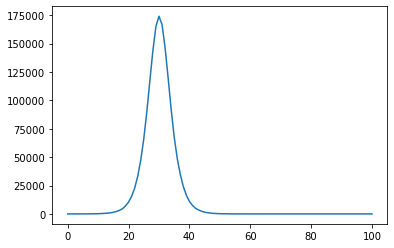

In [31]:
np.random.seed(0)
I, R = 1, 0
evolution = [1]
for t in range(100):
    I, R = new_infected(I, R, alpha=0.5, beta=1)
    evolution.append(I)
plt.plot(evolution)
plt.show()

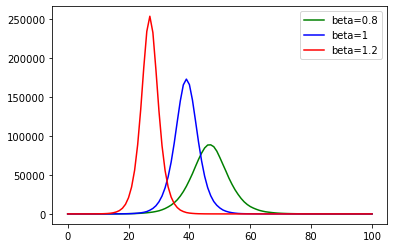

In [34]:
np.random.seed(0)
colors     = {0.8:'green', 1:'blue', 1.2:'red'}
evolutions = {0.8:[1],     1:[1],    1.2:[1]}
for b, evolution in evolutions.items():
    I, R = 1, 0
    for t in range(100):
        I, R = new_infected(I, R, alpha=0.5, beta=b)
        evolution.append(I)
    plt.plot(evolution, c=colors[b], label=f'beta={b}')
plt.legend()
plt.show()

Now, let's try to model an epidemic similar to COVID-19 : at first, normal contact rate is $\beta=1$. When the number of infected reach 10000 people, people start to panic and a lockdown is put into place for 15 days (renewable if not sufficient to reach below the critical number of 10000): $\beta=0.5$. Then, the lockdown is removed and we have again $\beta=1$. Etc.

At time 18 we reach 23494 cases
At time 54 we reach 20641 cases
At time 104 we reach 20971 cases


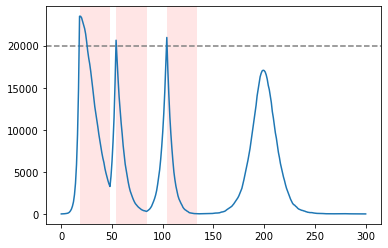

In [84]:
np.random.seed(0)
high_beta, low_beta = 1.1, 0.51
max_n = 20000
plt.axhline(y=max_n, c='grey', ls='--')
confinement = 30
def get_beta(I, t, start_t=None):
    if I < max_n and start_t is None:
        return high_beta, start_t
    else:
        if start_t is None:
            print(f'At time {t} we reach {I} cases')
            start_t = t
            plt.axvspan(t, t+30, alpha=0.1, facecolor='r')
        if t-start_t < confinement:
            return low_beta, start_t
        else:
            return get_beta(I, t, start_t=None)    
I, R = 1, 0
evolution = [1]
start_t = None
betas = []
for t in range(300):
    beta, start_t = get_beta(I, t, start_t)
    betas.append(beta)
    I, R = new_infected(I, R, alpha=0.49, beta=beta)
    evolution.append(I)
plt.plot(evolution)
plt.show()
# plt.plot(betas)
# plt.show()

Last representation : we include that there is a 7 days lag between the moment of infection and the moment it becomes visible.

At time 49 we reach 19601 cases
At time 115 we reach 12190 cases


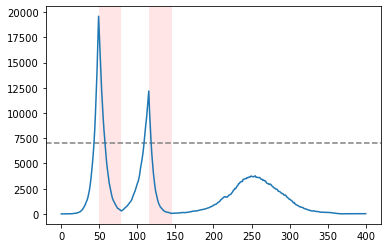

In [132]:
np.random.seed(0)
high_beta, low_beta = 0.7, 0.41
max_n = 7000
plt.axhline(y=max_n, c='grey', ls='--')
confinement = 30
lag = 7
def get_beta(evolution, t, start_t=None):
    if len(evolution)<7 or (evolution[-7] < max_n and start_t is None):
        return high_beta, start_t
    else:
        if start_t is None:
            print(f'At time {t} we reach {I} cases')
            start_t = t
            plt.axvspan(t, t+30, alpha=0.1, facecolor='r')
        if t-start_t < confinement:
            return low_beta, start_t
        else:
            return get_beta(evolution, t, start_t=None)    
I, R = 1, 0
evolution = [1]
start_t = None
betas = []
for t in range(400):
    beta, start_t = get_beta(evolution, t, start_t)
    betas.append(beta)
    I, R = new_infected(I, R, alpha=0.49, beta=beta)
    evolution.append(I)
plt.plot(evolution)
plt.show()
# plt.plot(betas)
# plt.show()

# Random Graphs

In [139]:
mu = 3 #average number of edges by person in the random graph
beta = 1.1 #contact rate
alpha = 0.5 #recover rate
tau = 1. #time points of contact

In [140]:
def edges(mu=mu):
    return poisson(mu)
def contact(tau=tau, T=dt):
    return poisson(tau*T)
def infected_period(alpha=alpha):
    return exponential(alpha)

In [239]:
class PoissonianNetwork:
    def __init__(self, N, mu, alpha=alpha, beta=beta, tau=tau, seed=0):
        self.N = N
        self.alpha=alpha
        self.beta=beta
        self.mu = mu
        self.tau = tau
        self.p = mu/(N-1)
        self.graph = {i:[] for i in range(N)}
        self.seed = seed
    
    def init(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        else:
            np.random.seed(self.seed)
    
    def build_graph(self, seed=None):
        print(f'Building contact graph...')
        time.sleep(1)
        self.init(seed)
        E = 0
        for i in tqdm(range(self.N-1)):
            edges = binomial(1, self.p, size=self.N-i-1).tolist()
            for j in np.nonzero(edges)[0]:
                E += 1
                self.graph[i].append(i+1+j)
                self.graph[i+1+j].append(i)
        time.sleep(1)
        print(f'Contact graph ready, with a total {E} edges !')
                
    def simul_epidemic(self, dt=dt, seed=None):
        self.init(seed)
        self.sick = []
        self.contaminated = []
        self.times = []
        I, i0 = 1, np.random.choice(self.N)
        self.already_contaminated = [i0]
        self.contagious = {i:-1 for i in range(self.N)}
        self.contagious[i0] = infected_period(self.alpha)
        time = 0
        self.sick.append(sum([T>0 for i,T in self.contagious.items()]))
        while self.sick[-1] > 0:
            self.contaminated.append(len(self.already_contaminated))
            print(f'At time {round(time*dt,1)} we have {round(100*len(self.already_contaminated)/self.N, 2)}% of population contaminated')
            self.times.append(time*dt)
            time += 1
            for i,T in filter(lambda tup:tup[1]>0, self.contagious.items()):
                for j in filter(lambda x: x not in self.already_contaminated,self.graph[i]):
                    contacts = poisson(self.tau*min(dt,T))
                    if contacts>0:
                        self.already_contaminated.append(j)
                        self.contagious[j] = infected_period(self.alpha)
                self.contagious[i] -= dt
            self.sick.append(sum([T>0 for i,T in self.contagious.items()]))
        self.sick.pop()
        print(f'Total contaminated portion of population : {round(len(self.already_contaminated)*100/self.N, 2)}%')
    
    def plot(self, dt, seed=None):
        self.simul_epidemic(dt, seed)
        plt.figure(figsize=(10,10))
        plt.plot(self.times, self.sick, c='r', label='simultaneously infected')
        plt.plot(self.times, self.contaminated, c='b', label='total infected')
        plt.axhline(y=self.N, c='grey', ls='--')
        plt.xlabel('time')
        plt.xticks(np.arange(0,max(self.times)+1,1))
        plt.yticks(np.arange(0,self.N+1,10000))
        plt.ylabel('number of people')
        plt.legend()
        plt.show()

In [240]:
p = PoissonianNetwork(N=100000, mu=3, alpha=2, beta=1.1, tau=1., seed=0)
p.build_graph()

Building contact graph...


100%|███████████████████████████████████████████████████████████████████████████| 99999/99999 [05:17<00:00, 314.69it/s]


Contact graph ready, with a total 150247 edges !


At time 0.0 we have 0.0% of population contaminated
At time 0.5 we have 0.0% of population contaminated
At time 1.0 we have 0.01% of population contaminated
At time 1.5 we have 0.03% of population contaminated
At time 2.0 we have 0.07% of population contaminated
At time 2.5 we have 0.18% of population contaminated
At time 3.0 we have 0.37% of population contaminated
At time 3.5 we have 0.82% of population contaminated
At time 4.0 we have 1.69% of population contaminated
At time 4.5 we have 3.3% of population contaminated
At time 5.0 we have 6.44% of population contaminated
At time 5.5 we have 11.86% of population contaminated
At time 6.0 we have 20.6% of population contaminated
At time 6.5 we have 32.0% of population contaminated
At time 7.0 we have 44.35% of population contaminated
At time 7.5 we have 55.3% of population contaminated
At time 8.0 we have 63.59% of population contaminated
At time 8.5 we have 69.33% of population contaminated
At time 9.0 we have 73.05% of population cont

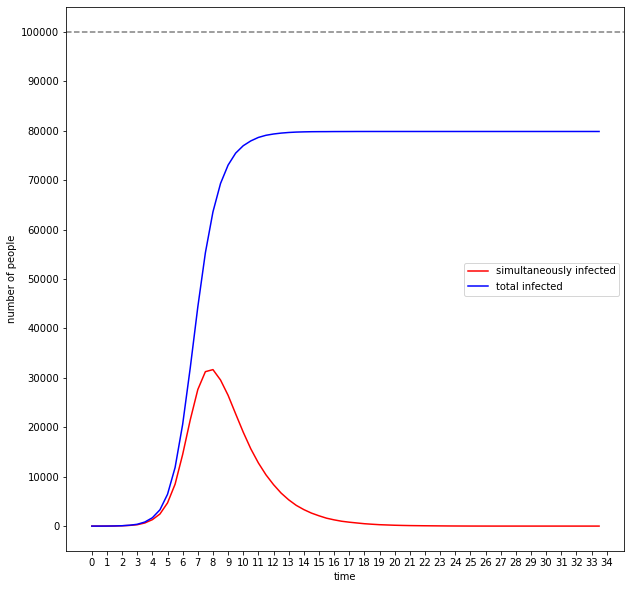

In [242]:
p.plot(0.5)

At time 0.0 we have 0.0% of population contaminated
At time 0.1 we have 0.0% of population contaminated
At time 0.2 we have 0.0% of population contaminated
At time 0.30000000000000004 we have 0.0% of population contaminated
At time 0.4 we have 0.0% of population contaminated
At time 0.5 we have 0.0% of population contaminated
At time 0.6000000000000001 we have 0.0% of population contaminated
At time 0.7000000000000001 we have 0.0% of population contaminated
At time 0.8 we have 0.0% of population contaminated
At time 0.9 we have 0.0% of population contaminated
At time 1.0 we have 0.0% of population contaminated
At time 1.1 we have 0.0% of population contaminated
At time 1.2000000000000002 we have 0.0% of population contaminated
At time 1.3 we have 0.0% of population contaminated
At time 1.4000000000000001 we have 0.01% of population contaminated
At time 1.5 we have 0.01% of population contaminated
At time 1.6 we have 0.01% of population contaminated
At time 1.7000000000000002 we have 0.

At time 13.9 we have 79.51% of population contaminated
At time 14.0 we have 79.52% of population contaminated
At time 14.100000000000001 we have 79.52% of population contaminated
At time 14.200000000000001 we have 79.53% of population contaminated
At time 14.3 we have 79.54% of population contaminated
At time 14.4 we have 79.55% of population contaminated
At time 14.5 we have 79.55% of population contaminated
At time 14.600000000000001 we have 79.56% of population contaminated
At time 14.700000000000001 we have 79.56% of population contaminated
At time 14.8 we have 79.57% of population contaminated
At time 14.9 we have 79.58% of population contaminated
At time 15.0 we have 79.58% of population contaminated
At time 15.100000000000001 we have 79.58% of population contaminated
At time 15.200000000000001 we have 79.59% of population contaminated
At time 15.3 we have 79.59% of population contaminated
At time 15.4 we have 79.59% of population contaminated
At time 15.5 we have 79.6% of popula

At time 27.700000000000003 we have 79.62% of population contaminated
At time 27.8 we have 79.62% of population contaminated
At time 27.900000000000002 we have 79.62% of population contaminated
At time 28.0 we have 79.62% of population contaminated
At time 28.1 we have 79.62% of population contaminated
At time 28.200000000000003 we have 79.62% of population contaminated
At time 28.3 we have 79.62% of population contaminated
At time 28.400000000000002 we have 79.62% of population contaminated
At time 28.5 we have 79.62% of population contaminated
At time 28.6 we have 79.62% of population contaminated
At time 28.700000000000003 we have 79.62% of population contaminated
At time 28.8 we have 79.62% of population contaminated
At time 28.900000000000002 we have 79.62% of population contaminated
At time 29.0 we have 79.62% of population contaminated
At time 29.1 we have 79.62% of population contaminated
At time 29.200000000000003 we have 79.62% of population contaminated
At time 29.3 we have 7

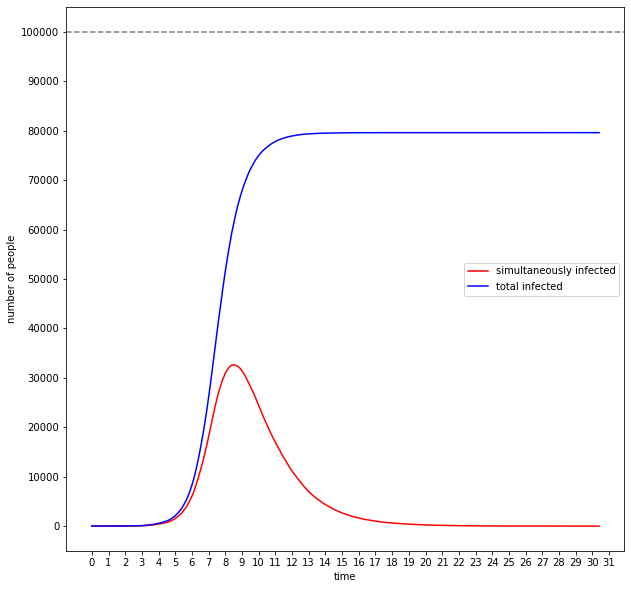

In [243]:
p.plot(0.1)

At time 0 we have 0.0% of population contaminated
At time 1 we have 0.0% of population contaminated
At time 2 we have 0.01% of population contaminated
At time 3 we have 0.02% of population contaminated
At time 4 we have 0.09% of population contaminated
At time 5 we have 0.33% of population contaminated
At time 6 we have 0.89% of population contaminated
At time 7 we have 2.65% of population contaminated
At time 8 we have 7.83% of population contaminated
At time 9 we have 20.4% of population contaminated
At time 10 we have 41.0% of population contaminated
At time 11 we have 59.61% of population contaminated
At time 12 we have 70.68% of population contaminated
At time 13 we have 75.75% of population contaminated
At time 14 we have 78.08% of population contaminated
At time 15 we have 79.03% of population contaminated
At time 16 we have 79.5% of population contaminated
At time 17 we have 79.67% of population contaminated
At time 18 we have 79.74% of population contaminated
At time 19 we hav

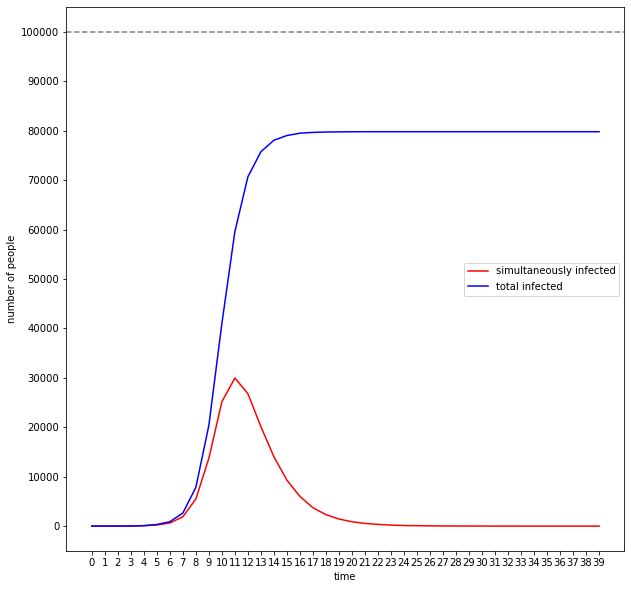

In [244]:
p.plot(1)

At time 0.0 we have 0.0% of population contaminated
At time 0.2 we have 0.0% of population contaminated
At time 0.4 we have 0.0% of population contaminated
At time 0.6000000000000001 we have 0.0% of population contaminated
At time 0.8 we have 0.0% of population contaminated
At time 1.0 we have 0.01% of population contaminated
At time 1.2000000000000002 we have 0.01% of population contaminated
At time 1.4000000000000001 we have 0.02% of population contaminated
At time 1.6 we have 0.02% of population contaminated
At time 1.8 we have 0.04% of population contaminated
At time 2.0 we have 0.05% of population contaminated
At time 2.2 we have 0.08% of population contaminated
At time 2.4000000000000004 we have 0.12% of population contaminated
At time 2.6 we have 0.16% of population contaminated
At time 2.8000000000000003 we have 0.23% of population contaminated
At time 3.0 we have 0.32% of population contaminated
At time 3.2 we have 0.47% of population contaminated
At time 3.4000000000000004 we

At time 28.400000000000002 we have 79.74% of population contaminated
At time 28.6 we have 79.74% of population contaminated
At time 28.8 we have 79.74% of population contaminated
At time 29.0 we have 79.74% of population contaminated
At time 29.200000000000003 we have 79.74% of population contaminated
At time 29.400000000000002 we have 79.74% of population contaminated
At time 29.6 we have 79.74% of population contaminated
At time 29.8 we have 79.74% of population contaminated
Total contaminated portion of population : 79.74%


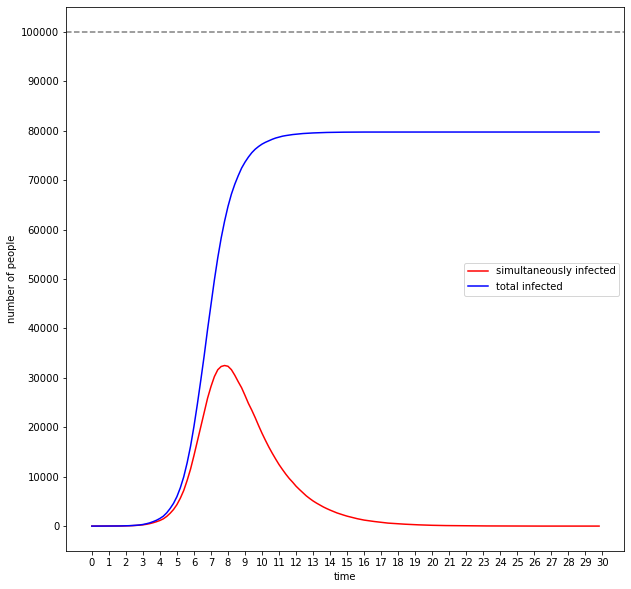

In [245]:
p.plot(0.2)